# Extracting Skills
This notebook documents an exploratory, data-driven process for understanding job postings through their required skills.
We begin by examining the data at the level of individual jobs, focusing on extracted skill sets that include both technical (hard) skills and softer, role-related skills.
Rather than relying on predefined job titles or manual labels, we investigate whether meaningful job roles can be discovered directly from the data by grouping jobs with similar titles and descriptions.
Using unsupervised clustering, we analyze how jobs naturally organize into role-like groups and then evaluate whether the associated skills are consistent within these groups and distinct across them.
The evaluation is performed using a similarity-based approach: we compare the overlap of extracted skills within the same inferred role to the overlap across different roles, and examine the resulting intra–inter similarity gap.
Throughout the notebook, we move from qualitative inspection to quantitative evaluation, using similarity-based metrics and visualizations to justify modeling choices and to assess the coherence of the extracted skills.

In [7]:
import pandas as pd
import ast
import re

all_data = pd.read_csv("Indeed Data/all_data.csv", low_memory=False)
cl = pd.read_csv("Indeed Data/clustering_4options.csv", low_memory=False)
gc = pd.read_csv("Indeed Data/Grouped_Clusters.csv", low_memory=False)

all_data.shape, cl.shape, gc.shape

((3635, 6), (647, 13), (39, 4))

Create CSV #1: job title + job description

In [20]:
import pandas as pd

# columns in all_data.csv are:
# - "Title" (job title)
# - "Full Job Description" (job description)

jobs_df = all_data[["Title", "Full Job Description"]].rename(
    columns={
        "Title": "job_title",
        "Full Job Description": "job_description"
    }
)

# Drop rows with missing title/description and remove duplicates
jobs_df = jobs_df.dropna(subset=["job_title", "job_description"]).drop_duplicates()

jobs_df.to_csv("jobs_title_description.csv", index=False, encoding="utf-8-sig")

jobs_df.head()

,job_title,job_description
0,Data Analytics,"Summary Posted: Nov 7, 2024 Role Number: 20057..."
1,Junior Backend Big Data Developer,"Israel, Hod HaSharon Description About ThetaRa..."
2,Data Annotator,Description: Prisma-Photonics is a rapidly gro...
3,Marketing Data Analyst,The Business Performance department at Plarium...
4,Junior Data Analyst,"aiOla is a high-growth, product-led SaaS start..."


In [22]:
jobs_df.shape

(399, 2)

In [14]:
print("clustering_4options columns:")
print(list(cl.columns))

print("\nGrouped_Clusters columns:")
print(list(gc.columns))

clustering_4options columns:
['Title', 'Company', 'Full Job Description', 'Search Word', 'Description', 'Description_English', 'Requirements_Text', 'Embeddings_Model1', 'Embeddings_Model2', 'Cluster_spark_KMeans_1', 'Cluster_spark_KMeans_2', 'Cluster_DBSCAN_Model1', 'Cluster_DBSCAN_Model2']

Grouped_Clusters columns:
['Cluster_Title', 'Num_Rows', 'Job_Titles', 'Clusters']


Prepare clustering information

In [57]:
import re
import pandas as pd

# Extended role families:
# - Data track: DA / DS / DE / BI / AE / MLE / NLP / CV / Data Quality
# - Product/Project: Product Manager / Project Manager / Program Manager
# - Customer-facing: Customer Success / Account Manager / Support
# - Software: Software Engineer / Frontend / Full Stack / Backend
# - Ops/Other business roles: Operations, etc.
# Order matters: first match wins.

ROLE_RULES = [
    # --- ML / AI specializations ---
    ("nlp", [
        r"\bnlp\b", r"\bnatural language processing\b", r"\blanguage model\b",
        r"\bllm\b", r"\bprompt engineer\b"
    ]),
    ("computer vision", [
        r"\bcomputer vision\b", r"\bimage\b.*\bmodel\b", r"\bvision\b.*\bmodel\b"
    ]),
    ("ml engineer", [
        r"\bmachine learning engineer\b", r"\bml engineer\b", r"\bmle\b",
        r"\bai engineer\b", r"\bmlops\b", r"\bmodel deployment\b",
        r"\bmachine learning developer\b", r"\bml developer\b"
    ]),

    ("product manager", [
        r"\bproduct manager\b", r"\bproduct management\b", r"\bpm\b(?!\s*2\.0)\b",
        r"\bjunior product manager\b", r"\bassociate product manager\b"
    ]),
    ("project manager", [
        r"\bproject manager\b", r"\bpmo\b", r"\bproject management\b",
        r"\bimplementation manager\b"
    ]),
    ("program manager", [
        r"\bprogram manager\b", r"\btechnical program manager\b", r"\btpm\b"
    ]),

    ("customer success", [
        r"\bcustomer success\b", r"\bclient success\b", r"\bcs manager\b"
    ]),
    ("account manager", [
        r"\baccount manager\b", r"\bkey account\b", r"\baccount executive\b"
    ]),
    ("support", [
        r"\bcustomer support\b", r"\bchat support\b", r"\bcustomer service\b"
    ]),
    ("operations", [
    r"\boperations\b", r"\bemployee experience\b", r"\boffice manager\b",
    r"\bpeople ops\b", r"\bhr operations\b"
    ]),

    ("software engineer", [
        r"\bsoftware engineer\b", r"\bsoftware developer\b", r"\bdeveloper\b",
        r"\bbackend\b", r"\bfront end\b|\bfrontend\b", r"\bfull stack\b",
        r"\bjava developer\b", r"\bengineer\b.*\bsoftware\b"
    ]),

    ("data engineer", [
        r"\bdata engineer\b",
        r"\betl developer\b", r"\betl engineer\b",
        r"\bairflow\b", r"\bdbt\b", r"\bkafka\b",
        r"\bdatabricks\b", r"\bspark\b",
        r"\bsnowflake\b", r"\bbigquery\b", r"\bredshift\b",
        r"\bdata warehouse\b"
    ]),

    ("analytics engineer", [
        r"\banalytics engineer\b"
    ]),

    ("bi analyst", [
        r"\bbi analyst\b", r"\bbusiness intelligence\b",
        r"\bpower bi\b", r"\btableau\b", r"\blook(er)?\b", r"\bmetabase\b"
    ]),

    ("product analyst", [
        r"\bproduct analyst\b", r"\bproduct analytics\b", r"\bgrowth analyst\b"
    ]),
    ("business analyst", [
        r"\bbusiness analyst\b", r"\bsystems analyst\b", r"\bprocess analyst\b"
    ]),
    ("data analyst", [
        r"\bdata analyst\b", r"\banalytics analyst\b", r"\bsql analyst\b",
        r"\breporting analyst\b", r"\binsights analyst\b", r"\bdashboard\b"
    ]),

    ("data scientist", [
        r"\bdata scientist\b", r"\bdata science\b",
        r"\bdecision scientist\b", r"\bstatistical modeling\b",
        r"\bpredictive modeling\b"
    ]),

    ("data quality", [
        r"\bdata quality\b", r"\bdata governance\b", r"\bdata steward\b"
    ]),

    ("data annotation", [
        r"\bdata annotator\b", r"\bdata annotation\b", r"\blabeling\b",
        r"\bannotation\b"
    ]),

    ("data entry", [
        r"\bdata entry\b", r"\binformation entry\b", r"\bclerk\b"
    ]),
    ("business other", [
    r"\bbrand manager\b",
    r"\bmarketing\b",
    r"\bpartnerships?\b",
    r"\bcontent\b",
    r"\breader\b",
    r"\btester\b",
    r"\bvocation\b|\btravel\b",
    r"\bgame\b.*\beconomy\b",
    r"\bapplication manager\b",
    r"\bstudy\b.*\bmanager\b",
    r"\bwork from home\b"
    ]),

    ("other", [r".*"])  # fallback
]

def normalize_text(x):
    x = "" if pd.isna(x) else str(x)
    x = x.lower()
    x = re.sub(r"\s+", " ", x).strip()
    return x

def assign_role_family(title, desc):
    text = normalize_text(title) + " " + normalize_text(desc)
    for family, patterns in ROLE_RULES:
        for pat in patterns:
            if re.search(pat, text):
                return family
    return "other"

# Apply classification
cl["role_family"] = cl.apply(
    lambda r: assign_role_family(r["Title"], r["Description_English"]),
    axis=1
)

cl["role_family"].value_counts()

role_family
operations           122
software engineer     79
data scientist        72
data engineer         58
product manager       57
nlp                   47
project manager       45
bi analyst            37
customer success      36
business other        27
support               15
computer vision       14
data analyst          12
data entry            10
account manager        7
ml engineer            5
other                  2
data quality           2
Name: count, dtype: int64

In [45]:
cl.loc[cl["role_family"]=="other", "Title"].value_counts().head(30)

Series([], Name: count, dtype: int64)

In [53]:
print("other rows:", (cl["role_family"] == "other").sum())
print("missing Title in other:", cl.loc[cl["role_family"]=="other", "Title"].isna().sum())
cl.loc[cl["role_family"]=="other", ["Title", "Company", "Description_English", "Requirements_Text"]].head(10)

other rows: 2
missing Title in other: 2


,Title,Company,Description_English,Requirements_Text
594,NaN,". After promising initial customer traction, w...",What to Expect You will be working with fellow...,Solid understanding of fundamental web technol...
646,NaN,and industry. It's essential to review the job...,Location : Remote / Flexible with occasional v...,rself and why you’re interested in this opport...


In [59]:
cl_to_save = cl.copy()

cl_to_save.to_csv(
    "jobs_with_role_family.csv",
    index=False,
    encoding="utf-8-sig"
)

cl_to_save.shape

(647, 14)

In [153]:
jobs_simple = cl[["Title", "Description_English"]].rename(
    columns={
        "Title": "job_title",
        "Description_English": "job_description"
    }
)

jobs_simple = jobs_simple.dropna(subset=["job_title", "job_description"]).drop_duplicates()

jobs_simple.to_csv(
    "jobs_title_description_only.csv",
    index=False,
    encoding="utf-8-sig"
)

jobs_simple.head()

,job_title,job_description
0,Data Analytics,"Summary Posted: Nov 7, 2024 Role Number: 20057..."
1,Junior Backend Big Data Developer,"Israel, Hod HaSharon Description About ThetaRa..."
2,Data Annotator,Description: Prisma-Photonics is a rapidly gro...
3,Marketing Data Analyst,The Business Performance department at Plarium...
4,Junior Data Analyst,"aiOla is a high-growth, product-led SaaS start..."


In [155]:
df1 = pd.read_csv("jobs_title_description_only.csv")
df2 = pd.read_csv("Job Descriptions.csv")

df1.shape, df2.shape

((302, 2), (171, 2))

In [161]:
df1 = pd.read_csv("jobs_title_description_only.csv")
df2 = pd.read_csv("Job Descriptions.csv")

# Normalize column names
df2 = df2.rename(columns={
    "Title": "job_title",
    "Description": "job_description"
})

df1 = df1[["job_title", "job_description"]]
df2 = df2[["job_title", "job_description"]]

# Merge and remove exact duplicates
jobs_merged = pd.concat([df1, df2], ignore_index=True).drop_duplicates()

# Overwrite the original file with the merged data
jobs_merged.to_csv(
    "jobs_title_description_only.csv",
    index=False,
    encoding="utf-8-sig"
)

jobs_merged.shape

(473, 2)

In [163]:
jobs_simple = cl[["Title", "Description_English", "Requirements_Text"]].rename(
    columns={
        "Title": "job_title",
        "Description_English": "job_description",
        "Requirements_Text": "job_requirements"
    }
)
jobs_simple = jobs_simple.dropna(subset=["job_title", "job_description"])
jobs_simple = jobs_simple.drop_duplicates()

jobs_simple.to_csv(
    "jobs_title_description_requirements.csv",
    index=False,
    encoding="utf-8-sig"
)

jobs_simple.head()

,job_title,job_description,job_requirements
0,Data Analytics,"Summary Posted: Nov 7, 2024 Role Number: 20057...",+3 years of experience Ability to lead data in...
1,Junior Backend Big Data Developer,"Israel, Hod HaSharon Description About ThetaRa...","into actionable designs and tasks, development..."
2,Data Annotator,Description: Prisma-Photonics is a rapidly gro...,A Bachelor of Science degree or equivalent (ST...
3,Marketing Data Analyst,The Business Performance department at Plarium...,B.A/BSc in a highly quantitative field such as...
4,Junior Data Analyst,"aiOla is a high-growth, product-led SaaS start...","B.Sc in Industrial Engineering, Data Analytics..."


extract_skills- extract a raw skill list from requirements text

In [167]:
STOP_PHRASES = {
    "communication skills", "excellent communication", "team player",
    "problem solving", "attention to detail", "self-motivated",
    "fast learner", "bachelor's degree", "master's degree",
    "years of experience", "experience"
}

def extract_skills(requirements_text):
    """
    Extract short skill-like phrases from a free-text requirements field.

    This is a heuristic approach:
    - split by bullets / commas / line breaks
    - keep short phrases that look like skills
    - drop generic HR phrases
    """
    if pd.isna(requirements_text) or not str(requirements_text).strip():
        return []

    text = str(requirements_text)

    # Normalize bullet points into line breaks
    text = text.replace("•", "\n").replace("·", "\n").replace("\u2022", "\n")

    parts = re.split(r"[\n,;/|]+", text)

    skills = []
    for p in parts:
        s = p.strip(" -–—\t\r:•*").strip()
        if not s:
            continue

        # Normalize spaces
        s = re.sub(r"\s+", " ", s)
        low = s.lower()

        # Heuristic filters (remove long sentences / generic phrases)
        if len(s) > 60:
            continue
        if len(s.split()) > 8:
            continue
        if any(sp in low for sp in STOP_PHRASES):
            continue

        # Require at least one Latin letter (avoid pure symbols / numbers)
        if not re.search(r"[A-Za-z]", s):
            continue

        skills.append(s)

    # De-duplicate while preserving order
    seen = set()
    unique_skills = []
    for s in skills:
        k = s.lower()
        if k not in seen:
            seen.add(k)
            unique_skills.append(s)

    return unique_skills

Count skills per role family

In [170]:
from collections import defaultdict

# Dictionaries to store counts
# role_family -> (skill -> count)
skill_counts = defaultdict(lambda: defaultdict(int))

# role_family -> number of jobs
role_job_counts = defaultdict(int)

# Iterate over all job postings
for _, row in cl.iterrows():
    role = row["role_family"]
    role_job_counts[role] += 1

    # Extract skills from the requirements text
    skills = extract_skills(row["Requirements_Text"])

    # Count each skill once per job posting
    for s in set(skills):
        skill_counts[role][s] += 1

In [172]:
len(skill_counts), len(role_job_counts)

(16, 18)

In [174]:
list(role_job_counts.keys())

['data engineer',
 'software engineer',
 'operations',
 'customer success',
 'product manager',
 'support',
 'nlp',
 'data scientist',
 'ml engineer',
 'data analyst',
 'computer vision',
 'bi analyst',
 'business other',
 'project manager',
 'account manager',
 'other',
 'data entry',
 'data quality']

In [176]:
dict(role_job_counts)

{'data engineer': 58,
 'software engineer': 79,
 'operations': 122,
 'customer success': 36,
 'product manager': 57,
 'support': 15,
 'nlp': 47,
 'data scientist': 72,
 'ml engineer': 5,
 'data analyst': 12,
 'computer vision': 14,
 'bi analyst': 37,
 'business other': 27,
 'project manager': 45,
 'account manager': 7,
 'other': 2,
 'data entry': 10,
 'data quality': 2}

In [178]:
cl["role_family"].value_counts()

role_family
operations           122
software engineer     79
data scientist        72
data engineer         58
product manager       57
nlp                   47
project manager       45
bi analyst            37
customer success      36
business other        27
support               15
computer vision       14
data analyst          12
data entry            10
account manager        7
ml engineer            5
other                  2
data quality           2
Name: count, dtype: int64

In [180]:
list(skill_counts["data scientist"].items())[:20]

[('Requirements: A minimum first degree in computer science', 5),
 ('R', 17),
 ('applied math', 5),
 ('creative', 17),
 ('distributed processing', 17),
 ('results driven', 17),
 ('artificial neural networks', 16),
 ('decision tree learning', 16),
 ('Economics', 3),
 ('data mining', 9),
 ('engineering', 9),
 ('Mathematics', 9),
 ('Statistics', 9),
 ('feature engineering', 9),
 ('gathering', 9),
 ('Computer Science', 9),
 ('statistical modeling', 9),
 ('Bioinformatics', 5),
 ('caret', 5),
 ('statistics', 5)]

In [182]:
row = cl.iloc[0]
print(row["Requirements_Text"])
print(extract_skills(row["Requirements_Text"]))

+3 years of experience Ability to lead data investigations and analysis projects with ambiguous requirements Advanced statistic and modeling knowledge Experience visualizing and presenting analyses in tools like Jupyter and Tableau Experience programming in Python in a professional setting Familiarity with distributed computation, storage, and workflow management (e.g. Splunk, Spark, Kubernetes, Kafka, Hadoop, MapReduce, AirFlow etc.) Experience with relational databases and SQL Highly organized, creative, motivated, and passionate about achieving results Curious and have excellent analytical and problem solving skills Excellent written, verbal, and data communication skills Bachelor's or Master's degree in computer science. Preferred Qualifications Familiarity with distributed computation, storage, and workflow management (e.g. Splunk, Spark, Kubernetes, Kafka, Hadoop, MapReduce, AirFlow etc.)
['storage', 'and workflow management (e.g. Splunk', 'Spark', 'Kubernetes', 'Kafka', 'Hadoop'

In [184]:
{role: len(skills) for role, skills in skill_counts.items()}

{'data engineer': 206,
 'software engineer': 163,
 'operations': 227,
 'customer success': 46,
 'product manager': 85,
 'support': 35,
 'nlp': 117,
 'data scientist': 32,
 'ml engineer': 23,
 'data analyst': 44,
 'computer vision': 63,
 'bi analyst': 97,
 'business other': 30,
 'project manager': 77,
 'other': 25,
 'data entry': 11}

Select “relevant” skills per role (by frequency)

In [188]:
# Step 1: Select "relevant" skills per role_family by frequency.
# We use different thresholds for technical vs. non-technical roles:
# - Technical roles tend to have more consistent stacks -> higher threshold
# - Non-technical roles are more heterogeneous -> lower threshold
# We also skip very small role groups to avoid unstable results.

TECH_ROLES = {
    "data engineer", "data scientist", "ml engineer",
    "nlp", "computer vision", "software engineer", "bi analyst"
}

TECH_THRESHOLD = 0.20      # 20% for technical roles
NONTECH_THRESHOLD = 0.10   # 10% for non-technical roles
MIN_JOBS_PER_ROLE = 5      # skip tiny groups (e.g., only 2 jobs)

role_relevant_skills = {}  # role_family -> list of relevant skills

for role, counts in skill_counts.items():
    total_jobs = role_job_counts[role]

    # Skip very small groups (unstable)
    if total_jobs < MIN_JOBS_PER_ROLE:
        continue

    # Choose threshold based on role type
    threshold = TECH_THRESHOLD if role in TECH_ROLES else NONTECH_THRESHOLD

    # Keep skills that appear in at least `threshold` fraction of jobs in that role
    relevant = [
        skill for skill, c in counts.items()
        if (c / total_jobs) >= threshold
    ]

    # Sort for readability
    role_relevant_skills[role] = sorted(relevant, key=str.lower)

# Quick check: number of relevant skills per role
{k: len(v) for k, v in role_relevant_skills.items()}

{'data engineer': 12,
 'software engineer': 4,
 'operations': 10,
 'customer success': 32,
 'product manager': 50,
 'support': 9,
 'nlp': 46,
 'data scientist': 6,
 'ml engineer': 23,
 'data analyst': 8,
 'computer vision': 1,
 'bi analyst': 7,
 'business other': 14,
 'project manager': 19,
 'data entry': 11}

Clean the relevant skill lists (soft skills + junk phrases)

In [191]:
import re
import pandas as pd
from collections import defaultdict, Counter

# -----------------------------
# Configuration
# -----------------------------

TECH_ROLES = {
    "data engineer", "data scientist", "ml engineer",
    "nlp", "computer vision", "software engineer", "bi analyst"
}

TECH_THRESHOLD = 0.20      # 20% for technical roles
NONTECH_THRESHOLD = 0.10   # 10% for non-technical roles
MIN_JOBS_PER_ROLE = 5

# Controlled soft-skill taxonomy
SOFT_SKILL_PATTERNS = {
    "communication": [r"\bcommunication\b", r"\bcommunicat(e|ing|ion)\b"],
    "teamwork": [r"\bteam player\b", r"\bteamwork\b", r"\bcollaborat(e|ion)\b"],
    "problem_solving": [r"\bproblem solving\b", r"\bproblem-solv", r"\banalytical\b", r"\bcritical thinking\b"],
    "organization": [r"\borganized\b", r"\borganization\b", r"\bdetail[- ]oriented\b", r"\battention to detail\b"],
    "initiative": [r"\bself[- ]motivated\b", r"\bproactive\b", r"\bownership\b", r"\bindependent\b"],
    "time_management": [r"\btime management\b", r"\bprioritiz(e|ation)\b", r"\bdeadline\b"],
    "leadership": [r"\bleadership\b", r"\bmentor\b", r"\bstakeholder management\b"],
}

# -----------------------------
# Helper functions
# -----------------------------

def extract_soft_skills_from_text(text):
    """
    Extract canonical soft-skill labels from the full requirements text.
    """
    if pd.isna(text) or not str(text).strip():
        return []
    t = str(text).lower()

    found = []
    for label, patterns in SOFT_SKILL_PATTERNS.items():
        for pat in patterns:
            if re.search(pat, t):
                found.append(label)
                break
    return sorted(set(found))

def dedup_preserve_order(lst):
    seen = set()
    out = []
    for x in lst:
        k = str(x).lower().strip()
        if k not in seen:
            seen.add(k)
            out.append(x)
    return out

# -----------------------------
# HARD skills: frequency-based (from skill_counts)
# -----------------------------

role_relevant_hard_skills = {}

for role, counts in skill_counts.items():
    total_jobs = role_job_counts[role]

    if total_jobs < MIN_JOBS_PER_ROLE:
        continue

    threshold = TECH_THRESHOLD if role in TECH_ROLES else NONTECH_THRESHOLD

    hard = [
        skill for skill, c in counts.items()
        if (c / total_jobs) >= threshold
    ]

    role_relevant_hard_skills[role] = sorted(
        dedup_preserve_order(hard),
        key=str.lower
    )

# -----------------------------
# SOFT skills: extracted from full Requirements_Text
# -----------------------------

soft_counts = defaultdict(Counter)

for _, row in cl.iterrows():
    role = row["role_family"]
    softs = extract_soft_skills_from_text(row["Requirements_Text"])
    for s in set(softs):
        soft_counts[role][s] += 1

role_relevant_soft_skills = {}

for role, counter in soft_counts.items():
    total_jobs = role_job_counts[role]

    if total_jobs < MIN_JOBS_PER_ROLE:
        continue

    kept = [
        label for label, c in counter.items()
        if (c / total_jobs) >= NONTECH_THRESHOLD
    ]

    role_relevant_soft_skills[role] = sorted(kept)

# -----------------------------
# Final table
# -----------------------------

rows = []
for role in sorted(role_job_counts.keys()):
    rows.append({
        "role_family": role,
        "n_jobs": role_job_counts[role],
        "hard_skills": " | ".join(role_relevant_hard_skills.get(role, [])),
        "soft_skills": " | ".join(role_relevant_soft_skills.get(role, [])),
        "num_hard_skills": len(role_relevant_hard_skills.get(role, [])),
        "num_soft_skills": len(role_relevant_soft_skills.get(role, [])),
    })

role_skills_df = pd.DataFrame(rows).sort_values("n_jobs", ascending=False)

# Save final CSV
role_skills_df.to_csv(
    "role_family_hard_and_soft_skills.csv",
    index=False,
    encoding="utf-8-sig"
)

# -----------------------------
# Quick sanity checks
# -----------------------------
print(role_skills_df[["role_family", "num_hard_skills", "num_soft_skills"]])

# Example inspection
print("\nProduct Manager – hard skills:")
print(role_skills_df.loc[role_skills_df["role_family"]=="product manager", "hard_skills"].iloc[0])

print("\nProduct Manager – soft skills:")
print(role_skills_df.loc[role_skills_df["role_family"]=="product manager", "soft_skills"].iloc[0])

          role_family  num_hard_skills  num_soft_skills
12         operations               10                6
16  software engineer                4                6
9      data scientist                6                3
6       data engineer               12                5
14    product manager               50                3
11                nlp               46                5
15    project manager               19                5
1          bi analyst                7                6
4    customer success               32                4
2      business other               14                4
17            support                9                3
3     computer vision                1                3
5        data analyst                8                3
7          data entry               10                4
0     account manager                0                0
10        ml engineer               23                4
8        data quality                0          

In [193]:
import re

ROLE_NAMES = {
    "data engineer", "data scientist", "software engineer",
    "ml engineer", "product manager", "project manager",
    "bi analyst", "data analyst"
}

def is_valid_hard_skill(s):
    if not s or not isinstance(s, str):
        return False

    low = s.lower().strip()

    # Too long / sentence-like
    if len(low) > 40:
        return False
    if len(low.split()) > 5:
        return False

    # EEO / legal / compensation keywords
    if any(x in low for x in [
        "age", "gender", "citizenship", "national origin", "disability",
        "salary", "compensation", "bonus", "equity", "protected by law",
        "religion", "veteran", "marital"
    ]):
        return False

    # Role names are not skills
    if low in ROLE_NAMES:
        return False

    # Very generic words
    if low in {"engineering", "qualifications", "training", "status"}:
        return False

    # Must contain at least one letter
    if not re.search(r"[a-z]", low):
        return False

    return True


# Apply final hard-skill cleaning
for role in role_relevant_hard_skills:
    role_relevant_hard_skills[role] = [
        s for s in role_relevant_hard_skills[role]
        if is_valid_hard_skill(s)
    ]

# Rebuild final table
rows = []
for role in sorted(role_job_counts.keys()):
    rows.append({
        "role_family": role,
        "n_jobs": role_job_counts[role],
        "hard_skills": " | ".join(role_relevant_hard_skills.get(role, [])),
        "soft_skills": " | ".join(role_relevant_soft_skills.get(role, [])),
        "num_hard_skills": len(role_relevant_hard_skills.get(role, [])),
        "num_soft_skills": len(role_relevant_soft_skills.get(role, [])),
    })

role_skills_df = pd.DataFrame(rows).sort_values("n_jobs", ascending=False)

In [195]:
import re

ROLE_NAMES = {
    "data engineer", "data scientist", "software engineer",
    "ml engineer", "product manager", "project manager",
    "bi analyst", "data analyst"
}

def is_valid_hard_skill(s):
    if not s or not isinstance(s, str):
        return False

    low = s.lower().strip()

    # Too long / sentence-like
    if len(low) > 40:
        return False
    if len(low.split()) > 5:
        return False

    # EEO / legal / compensation keywords
    if any(x in low for x in [
        "age", "gender", "citizenship", "national origin", "disability",
        "salary", "compensation", "bonus", "equity", "protected by law",
        "religion", "veteran", "marital"
    ]):
        return False

    # Role names are not skills
    if low in ROLE_NAMES:
        return False

    # Very generic words
    if low in {"engineering", "qualifications", "training", "status"}:
        return False

    # Must contain at least one letter
    if not re.search(r"[a-z]", low):
        return False

    return True


# Apply final hard-skill cleaning
for role in role_relevant_hard_skills:
    role_relevant_hard_skills[role] = [
        s for s in role_relevant_hard_skills[role]
        if is_valid_hard_skill(s)
    ]

# Rebuild final table
rows = []
for role in sorted(role_job_counts.keys()):
    rows.append({
        "role_family": role,
        "n_jobs": role_job_counts[role],
        "hard_skills": " | ".join(role_relevant_hard_skills.get(role, [])),
        "soft_skills": " | ".join(role_relevant_soft_skills.get(role, [])),
        "num_hard_skills": len(role_relevant_hard_skills.get(role, [])),
        "num_soft_skills": len(role_relevant_soft_skills.get(role, [])),
    })

role_skills_df = pd.DataFrame(rows).sort_values("n_jobs", ascending=False)

In [197]:
import re

EEO_KEYWORDS = {
    "age", "ancestry", "citizenship", "color", "creed",
    "gender", "gender expression", "gender identity",
    "genetic information", "marital status", "national origin",
    "physical or mental disability", "political affiliation",
    "religion", "race", "sex", "sexual orientation",
    "veteran status"
}

GENERIC_JUNK = {
    "engineering", "qualifications", "training", "status"
}

ROLE_NAMES = {
    "data engineer", "data scientist", "software engineer",
    "ml engineer", "product manager", "project manager",
    "bi analyst", "data analyst"
}

def clean_hard_skills_cell(cell):
    if pd.isna(cell) or not str(cell).strip():
        return ""

    skills = [s.strip() for s in str(cell).split("|")]
    cleaned = []

    for s in skills:
        low = s.lower()

        # Drop EEO / legal
        if any(k in low for k in EEO_KEYWORDS):
            continue

        # Drop role names
        if low in ROLE_NAMES:
            continue

        # Drop generic junk
        if low in GENERIC_JUNK:
            continue

        # Drop sentence-like fragments
        if len(low.split()) > 5 or len(low) > 40:
            continue

        # Must contain at least one letter
        if not re.search(r"[a-z]", low):
            continue

        cleaned.append(s)

    return " | ".join(cleaned)


# Apply cleaning to the dataframe column
role_skills_df["hard_skills"] = role_skills_df["hard_skills"].apply(clean_hard_skills_cell)

# Update counts
role_skills_df["num_hard_skills"] = role_skills_df["hard_skills"].apply(
    lambda x: 0 if not x else len(x.split(" | "))
)

role_skills_df.loc[
    role_skills_df["role_family"]=="product manager",
    ["hard_skills","soft_skills","num_hard_skills"]
]

,hard_skills,soft_skills,num_hard_skills
14,Airflow | C# | C++ | data modeling | ETL | ETL...,communication | organization | problem_solving,20


In [199]:
role_skills_df.to_csv(
    "role_family_hard_and_soft_skills.csv",
    index=False,
    encoding="utf-8-sig"
)

In [202]:
import pandas as pd

# Build a table:
# - role_family
# - all_skills (hard + soft combined)
# - num_skills (count of combined skills)
# - n_jobs

def split_skills(s):
    if pd.isna(s) or not str(s).strip():
        return []
    return [x.strip() for x in str(s).split("|") if x.strip()]

rows = []
for _, r in role_skills_df.iterrows():
    hard = split_skills(r.get("hard_skills", ""))
    soft = split_skills(r.get("soft_skills", ""))

    seen = set()
    combined = []
    for x in hard + soft:
        k = x.lower()
        if k not in seen:
            seen.add(k)
            combined.append(x)

    rows.append({
        "role_family": r["role_family"],
        "skills": " | ".join(combined),
        "num_skills": len(combined),
        "n_jobs": r["n_jobs"]
    })

role_family_summary = pd.DataFrame(rows).sort_values("n_jobs", ascending=False)

role_family_summary.to_csv(
    "role_family_skills_summary.csv",
    index=False,
    encoding="utf-8-sig"
)

role_family_summary.head(20)

,role_family,skills,num_skills,n_jobs
0,operations,and | C++ | data engineering | data science | ...,10,122
1,software engineer,communication | leadership | organization | pr...,6,79
2,data scientist,artificial neural networks | creative | decisi...,9,72
3,data engineer,Mathematics | preprocessing | communication | ...,7,58
4,product manager,Airflow | C# | C++ | data modeling | ETL | ETL...,23,57
5,nlp,cloud | cloud environments | Computer Science ...,34,47
6,project manager,B.Sc. Industrial engineering | empathy | in a ...,11,45
7,bi analyst,and regulations (HIPAA | Computer Science | de...,12,37
8,customer success,Advertising | and Engineering | B.Sc in Indust...,27,36
9,business other,BSC degree in: Economics | Energetic | mathema...,15,27


In [215]:
# 1) Load the merged jobs file (this already includes both sources)
jobs = pd.read_csv("jobs_title_description_only.csv")

# 2) Extract hard skills from the job description text
jobs["hard_skills_extracted"] = jobs["job_description"].apply(lambda x: extract_skills(x))

# 3) Extract soft skills from the full job description text
jobs["soft_skills_extracted"] = jobs["job_description"].apply(lambda x: extract_soft_skills_from_text(x))

# 4) Combine hard + soft into one skills column (deduplicate, readable " | " format)
def combine_skills(hard_list, soft_list):
    hard_list = hard_list if isinstance(hard_list, list) else []
    soft_list = soft_list if isinstance(soft_list, list) else []

    seen = set()
    combined = []
    for s in hard_list + soft_list:
        k = str(s).strip().lower()
        if k and k not in seen:
            seen.add(k)
            combined.append(str(s).strip())

    return " | ".join(combined)

jobs["skills"] = jobs.apply(
    lambda r: combine_skills(r["hard_skills_extracted"], r["soft_skills_extracted"]),
    axis=1
)

jobs_partner_csv = jobs[["job_title", "job_description", "skills"]].copy()

jobs_partner_csv.to_csv(
    "jobs_title_description_skills.csv",
    index=False,
    encoding="utf-8-sig"
)

print("Saved: jobs_title_description_skills.csv")
jobs_partner_csv.head()

Saved: jobs_title_description_skills.csv


,job_title,job_description,skills
0,Data Analytics,"Summary Posted: Nov 7, 2024 Role Number: 20057...",Summary Posted: Nov 7 | including the iPhone |...
1,Junior Backend Big Data Developer,"Israel, Hod HaSharon Description About ThetaRa...",Israel | offering cutting-edge technology to f...
2,Data Annotator,Description: Prisma-Photonics is a rapidly gro...,smart cities | perimeters | grid monitoring | ...
3,Marketing Data Analyst,The Business Performance department at Plarium...,to user acquisition | player behavior | live-o...
4,Junior Data Analyst,"aiOla is a high-growth, product-led SaaS start...",aiOla is a high-growth | intelligence | collab...


In [294]:
jobs_partner_csv = pd.read_csv("jobs_title_description_skills.csv")

EEO_COMP_KEYWORDS = [
    "equal opportunity", "eeo", "eeoc", "discriminate", "accommodation",
    "age", "ancestry", "citizenship", "color", "creed", "gender",
    "gender identity", "gender expression", "genetic information",
    "marital", "national origin", "disability", "veteran",
    "religion", "race", "sexual orientation", "protected by law",
    "salary", "compensation", "bonus", "equity", "incentive", "benefits",
    "monthly rate", "annual salary", "affirmative action"
]

BAD_START = ("and ", "or ", "with ", "to ", "of ", "in ", "for ", "the ")

BAD_CONTAIN_PATTERNS = [
    r"\bsuch as\b", r"\be\.g\.?\b", r"\bi\.e\.?\b", r"\bincluding\b", r"\bfor example\b",
]

ALLOW_BRANDS = {
    "python", "r", "sql", "scala", "java", "c++", "c#", "matlab",
    "tableau", "power bi", "looker", "snowflake", "airflow",
    "kubernetes", "docker", "github", "git", "jira", "confluence",
    "spark", "hadoop", "kafka", "dbt", "databricks", "aws", "gcp", "azure",
    "tensorflow", "pytorch", "scikit-learn", "sklearn"
}

GENERIC_JUNK = {
    "requirements", "preferred qualifications", "qualifications",
    "engineering", "training", "status", "responsibilities", "about us"
}

DUTY_VERBS = {
    "prepare", "develop", "manage", "managing", "collaborate", "collaborating",
    "coordinate", "coordinating", "support", "supporting", "drive", "driving",
    "lead", "leading", "perform", "performing", "execute", "executing",
    "build", "building", "design", "designing", "deliver", "delivering",
    "implement", "implementing", "create", "creating", "maintain", "maintaining",
    "monitor", "monitoring"
}

BAD_FRAGMENT_PATTERNS = [
    r"^you will\b",
    r"^we are\b", r"^we're\b", r"^we\b",
    r"^our\b",
    r"^at\s+[a-z0-9&' -]{2,40},\b",    
    r"\bis expanding\b",
    r"\bis a\b", r"\bare a\b",
    r"\brole number\b",
    r"\bsummary posted\b",
    r"\bequips\b",                    
    r"\bemployer\b",                    
]

BAD_THEME_WORDS = [
    "culture", "belonging", "background", "equitable",
    "educational assistance", "assistance program", "benefits"
]

def split_skills(skills_str):
    if pd.isna(skills_str) or not str(skills_str).strip():
        return []
    return [s.strip() for s in str(skills_str).split("|") if s.strip()]

def looks_like_entity(raw: str) -> bool:
    t = raw.strip().strip("[]()'\"")
    return (len(t.split()) == 1) and (t[:1].isupper())

def has_too_much_punct(low: str) -> bool:
    weird = re.findall(r"[^\w\s#+\-.]", low)
    return len(weird) >= 2

def extract_allowlisted_from_sentence(text: str):
    """
    If a phrase contains allowlisted tools (e.g., 'preferably MATLAB and Python'),
    return those tools as skills.
    """
    low = text.lower()
    found = []
    for tool in ALLOW_BRANDS:
        if tool in low:
            found.append(tool)
    # Return in a stable order (nice for CSV)
    return sorted(set(found), key=str.lower)

def starts_with_duty_verb(low: str) -> bool:
    first = low.split(" ", 1)[0] if low else ""
    return first in DUTY_VERBS

def is_valid_skill(s: str) -> bool:
    if not s or not isinstance(s, str):
        return False

    raw = s.strip()
    low = raw.lower().strip()

    # Drop question-like tokens
    if "?" in low:
        return False

    # Drop ALL-CAPS headings
    if raw.isupper():
        return False

    # Drop benefits / DEI / culture phrases
    if any(w in low for w in BAD_THEME_WORDS):
        return False

    # Drop obvious sentence fragments / company slogans / employer statements
    if any(re.search(p, low) for p in BAD_FRAGMENT_PATTERNS):
        return False

    # Drop connector-start fragments
    if low.startswith(BAD_START):
        return False

    # Drop example-list phrases
    if any(re.search(p, low) for p in BAD_CONTAIN_PATTERNS):
        return False

    # Drop duty/responsibility phrases (start with verb)
    if starts_with_duty_verb(low):
        return False

    # Drop very long / sentence-like chunks
    if len(low) > 30:
        return False
    if len(low.split()) > 4:
        return False

    # Drop unbalanced bracket/parenthesis artifacts
    if low.count("[") != low.count("]"):
        return False
    if low.count("(") != low.count(")"):
        return False

    # Drop broken chunks with too much punctuation
    if has_too_much_punct(low):
        return False

    # Drop location/zip
    if "location:" in low:
        return False
    if re.search(r"\b\d{5}\b", low):
        return False

    # Drop money/percent
    if re.search(r"[$€£₪]|%\b", low):
        return False

    # Drop legal/EEO boilerplate
    if any(k in low for k in EEO_COMP_KEYWORDS):
        return False

    # Drop generic junk tokens
    if low in GENERIC_JUNK:
        return False

    # Must contain a letter
    if not re.search(r"[a-z]", low):
        return False
    # Explicitly allow programming languages with symbols
    if low in {"c#", "c++", "c"}:
        return True

    # Drop proper nouns that look like entities unless allowlisted
    if looks_like_entity(raw) and low not in ALLOW_BRANDS:
        if raw.istitle() or len(raw.split()) >= 2:
            return False

    return True

def clean_skills_cell(skills_str):
    skills = split_skills(skills_str)

    cleaned = []
    seen = set()

    for s in skills:
        s = s.strip()

        # if this is a sentence that contains allowlisted tools,
        # extract the tools instead of keeping the sentence
        extracted = extract_allowlisted_from_sentence(s)
        if extracted and (len(s.split()) > 2 or "prefer" in s.lower()):
            for tool in extracted:
                if tool not in seen:
                    seen.add(tool)
                    cleaned.append(tool)
            continue

        if not is_valid_skill(s):
            continue

        key = s.lower().strip()
        if key not in seen:
            seen.add(key)
            cleaned.append(s)

    return " | ".join(cleaned)

# 1) Clean per-job skills
jobs_partner_csv["skills"] = jobs_partner_csv["skills"].apply(clean_skills_cell)

# 2) Global frequency filter (remove rare random leftovers)
all_skills = []
for cell in jobs_partner_csv["skills"].fillna(""):
    all_skills.extend([x.strip().lower() for x in str(cell).split("|") if x.strip()])

freq = Counter(all_skills)
MIN_GLOBAL_FREQ = 2

def keep_by_global_freq(skills_str):
    items = [x.strip() for x in str(skills_str).split("|") if x.strip()]
    kept = []
    for x in items:
        lx = x.lower()
        if lx in ALLOW_BRANDS:
            kept.append(x)
        elif freq[lx] >= MIN_GLOBAL_FREQ:
            kept.append(x)
    return " | ".join(kept)

jobs_partner_csv["skills"] = jobs_partner_csv["skills"].apply(keep_by_global_freq)

out_path = "jobs_title_description_skills_clean.csv"
jobs_partner_csv.to_csv(out_path, index=False, encoding="utf-8-sig")
print("Saved:", out_path)

Saved: jobs_title_description_skills_clean.csv


In [297]:
import pandas as pd
import ast

df = pd.read_csv("jobs_title_description_skills_clean.csv")

def normalize_skills(cell):
    if pd.isna(cell) or not str(cell).strip():
        return []

    s = str(cell).strip()
    if s.startswith("[") and s.endswith("]"):
        try:
            parsed = ast.literal_eval(s)
        except Exception:
            parsed = []
    else:
        parsed = [x.strip() for x in s.split("|") if x.strip()]

    flat = []
    for item in parsed:
        if isinstance(item, list):
            flat.extend(item)
        else:
            flat.append(item)

    seen = set()
    clean = []
    for x in flat:
        x = str(x).strip()
        key = x.lower()
        if x and key not in seen:
            seen.add(key)
            clean.append(x)

    return clean


df["skills"] = df["skills"].apply(normalize_skills)

df["skills"] = df["skills"].apply(
    lambda lst: "[" + ", ".join(lst) + "]"
)

df.to_csv(
    "jobs_title_description_skills_clean.csv",
    index=False,
    encoding="utf-8-sig"
)

df.head(10)

,job_title,job_description,skills
0,Data Analytics,"Summary Posted: Nov 7, 2024 Role Number: 20057...","[r, Spark, Kubernetes, Kafka, Hadoop, creative..."
1,Junior Backend Big Data Developer,"Israel, Hod HaSharon Description About ThetaRa...","[r, banks, inclusive, development, Hadoop, Doc..."
2,Data Annotator,Description: Prisma-Photonics is a rapidly gro...,"[smart cities, perimeters, grid monitoring, r,..."
3,Marketing Data Analyst,The Business Performance department at Plarium...,"[r, player behavior, live-ops, retention, stra..."
4,Junior Data Analyst,"aiOla is a high-growth, product-led SaaS start...","[r, intelligence, collaboration, Data Science,..."
5,Data Engineer,"As a Data Engineer at Meta, you will shape the...","[r, WhatsApp, Reality Labs, data science, stra..."
6,Junior Data Engineer,"At Aquant, we empower field service profession...","[At Aquant, r, field technicians, reduce costs..."
7,Data Scientist,About Team & About Role: Rubrik is seeking a D...,"[pattern analysis, Computer Science, r, NumPy,..."
8,data scientist!,"A large, technologically leading organization ...","[A large, sql, data engineering, data science,..."
9,Data Scientist,jb-19 Job Number: With experience in Data Scie...,"[applied math, creative, results driven, distr..."


Evaluation- DBSCAN Stability

To evaluate the quality of the semantic clustering stage, we analyze the stability of DBSCAN under different hyperparameter settings.
Since DBSCAN does not require a predefined number of clusters, stability across ε values is a common proxy for cluster robustness in unsupervised settings.
We focus on structural stability rather than semantic labels.

In [327]:
import os
import ast
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

In [329]:
path_candidates = [
    "clustering_4options.csv",
    "Indeed Data/clustering_4options.csv",
    "./Indeed Data/clustering_4options.csv",
]
csv_path = next((p for p in path_candidates if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError("Could not find clustering_4options.csv in expected locations.")

cl = pd.read_csv(csv_path)
cl.columns = cl.columns.str.strip()
print("Using:", csv_path)
print("Columns:", list(cl.columns))

EMB_COL = "Embeddings_Model1"
if EMB_COL not in cl.columns:
    raise ValueError(f"Missing {EMB_COL}. Available columns: {list(cl.columns)}")

Using: Indeed Data/clustering_4options.csv
Columns: ['Title', 'Company', 'Full Job Description', 'Search Word', 'Description', 'Description_English', 'Requirements_Text', 'Embeddings_Model1', 'Embeddings_Model2', 'Cluster_spark_KMeans_1', 'Cluster_spark_KMeans_2', 'Cluster_DBSCAN_Model1', 'Cluster_DBSCAN_Model2']


In [331]:
# Parse embeddings (stored as string like "[0.1, 0.2, ...]")
def parse_emb(x):
    if pd.isna(x):
        return None
    if isinstance(x, (list, np.ndarray)):
        return np.array(x, dtype=float)
    s = str(x).strip()
    try:
        arr = np.array(ast.literal_eval(s), dtype=float)
        return arr
    except Exception:
        return None

emb_list = cl[EMB_COL].apply(parse_emb)
mask_ok = emb_list.notna()
X = np.vstack(emb_list[mask_ok].values)
print("Rows with valid embeddings:", X.shape[0], "/", cl.shape[0])

Rows with valid embeddings: 647 / 647


In [333]:
# DBSCAN stability: vary eps and compare outputs
eps_grid = [0.30, 0.35, 0.40, 0.45, 0.50]   
min_samples = 5                          

results = []
labels_by_eps = {}

for eps in eps_grid:
    db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine", n_jobs=-1)
    labels = db.fit_predict(X)

    n_noise = int(np.sum(labels == -1))
    n_clusters = int(len(set(labels)) - (1 if -1 in labels else 0))
    noise_pct = round(100 * n_noise / len(labels), 1)

    results.append({
        "eps": eps,
        "min_samples": min_samples,
        "n_clusters": n_clusters,
        "noise_pct": noise_pct
    })
    labels_by_eps[eps] = labels

summary = pd.DataFrame(results)
print("\nDBSCAN summary (structure):")
display(summary)


DBSCAN summary (structure):


,eps,min_samples,n_clusters,noise_pct
0,0.30,5,30,17.2
1,0.35,5,22,11.6
2,0.40,5,12,10.0
3,0.45,5,6,7.7
4,0.50,5,4,4.0


As epsilon increases, the number of clusters decreases while the percentage of noise points is reduced.
This behavior is expected in DBSCAN: larger neighborhoods merge nearby clusters and absorb more points into dense regions.
The results indicate a smooth structural transition rather than abrupt changes.

In [335]:
# Stability metric: ARI between eps settings
ari_rows = []
for i in range(len(eps_grid) - 1):
    e1, e2 = eps_grid[i], eps_grid[i + 1]
    ari = adjusted_rand_score(labels_by_eps[e1], labels_by_eps[e2])
    ari_rows.append({"eps_1": e1, "eps_2": e2, "ARI": round(ari, 3)})

ari_df = pd.DataFrame(ari_rows)
print("\nStability between consecutive eps (higher ARI = more stable):")
display(ari_df)


Stability between consecutive eps (higher ARI = more stable):


,eps_1,eps_2,ARI
0,0.30,0.35,0.639
1,0.35,0.40,0.607
2,0.40,0.45,0.674
3,0.45,0.50,0.625


The Adjusted Rand Index (ARI) between consecutive epsilon values ranges between 0.60 and 0.67.
These relatively high scores indicate that cluster assignments remain largely consistent under small perturbations of epsilon.
This suggests that the clustering structure is not overly sensitive to hyperparameter tuning.

In [339]:
# full ARI matrix (eps x eps)
ari_matrix = pd.DataFrame(index=eps_grid, columns=eps_grid, dtype=float)
for e1 in eps_grid:
    for e2 in eps_grid:
        ari_matrix.loc[e1, e2] = adjusted_rand_score(labels_by_eps[e1], labels_by_eps[e2])

print("\nARI matrix:")
display(ari_matrix.round(3))


ARI matrix:


,0.30,0.35,0.40,0.45,0.50
0.30,1.000,0.639,0.333,0.175,0.083
0.35,0.639,1.000,0.607,0.361,0.180
0.40,0.333,0.607,1.000,0.674,0.377
0.45,0.175,0.361,0.674,1.000,0.625
0.50,0.083,0.180,0.377,0.625,1.000


The full ARI matrix shows high agreement mainly along the diagonal and between nearby epsilon values, while agreement drops as epsilon differences grow.
This pattern is consistent with gradual cluster merging rather than unstable re-partitioning, further supporting the robustness of the DBSCAN solution.

Overall, the DBSCAN clustering demonstrates reasonable stability across a meaningful range of epsilon values.
This supports the use of the resulting clusters as a basis for downstream analysis, including role-family grouping and skill aggregation.
While stability does not guarantee semantic correctness, it provides evidence that the embedding space contains coherent and well-separated regions.

Evaluation- Extracting Skills

In [351]:
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [357]:
csv_path = "jobs_title_description_skills_clean.csv"  
df = pd.read_csv(csv_path)
df.columns.tolist()
print(df.shape)
df.head(3)

(473, 3)


,job_title,job_description,skills
0,Data Analytics,"Summary Posted: Nov 7, 2024 Role Number: 20057...","[r, Spark, Kubernetes, Kafka, Hadoop, creative..."
1,Junior Backend Big Data Developer,"Israel, Hod HaSharon Description About ThetaRa...","[r, banks, inclusive, development, Hadoop, Doc..."
2,Data Annotator,Description: Prisma-Photonics is a rapidly gro...,"[smart cities, perimeters, grid monitoring, r,..."


In [361]:
df["text_for_clustering"] = (
    df["job_title"].fillna("").astype(str)
    + " || "
    + df["job_description"].fillna("").astype(str)
).str.lower()

df["text_for_clustering"].head(2)

0    data analytics || summary posted: nov 7, 2024 ...
1    junior backend big data developer || israel, h...
Name: text_for_clustering, dtype: object

In [379]:
def short_desc(text, n_chars=300):
    if pd.isna(text):
        return ""
    return text[:n_chars]

df["text_for_clustering"] = (
    df["job_title"]
    + " || "
    + df["job_description"].apply(short_desc)
).str.lower()

In [381]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words="english",
    min_df=2
)

X_tfidf = tfidf.fit_transform(df["text_for_clustering"])

X_tfidf.shape

(473, 4206)

In [383]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

svd = TruncatedSVD(n_components=200, random_state=42)
X = svd.fit_transform(X_tfidf)

X = normalize(X)

X.shape

(473, 200)

In [385]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 10
nn = NearestNeighbors(n_neighbors=k, metric="cosine").fit(X)
distances, _ = nn.kneighbors(X)

k_dist = np.sort(distances[:, -1])

np.percentile(k_dist, [90, 95, 97, 98, 99])

array([0.94082305, 0.94820594, 0.95456235, 0.95671462, 0.95927689])

In [392]:
from sklearn.cluster import DBSCAN
import numpy as np

def dbscan_stats(eps, min_samples=10):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise = (labels == -1).mean()
    biggest = np.max(np.bincount(labels[labels >= 0])) if n_clusters > 0 else 0
    return n_clusters, noise, biggest

eps_grid = np.round(np.arange(0.15, 0.91, 0.05), 2)  
rows = []
for eps in eps_grid:
    n_clusters, noise, biggest = dbscan_stats(eps, min_samples=10)
    rows.append((eps, n_clusters, round(noise, 3), biggest))

grid_df = pd.DataFrame(rows, columns=["eps", "n_clusters", "noise_ratio", "biggest_cluster_size"])
grid_df

,eps,n_clusters,noise_ratio,biggest_cluster_size
0,0.15,1,0.979,10
1,0.20,1,0.979,10
2,0.25,1,0.979,10
3,0.30,1,0.979,10
4,0.35,1,0.979,10
5,0.40,1,0.979,10
6,0.45,1,0.979,10
7,0.50,1,0.979,10
8,0.55,1,0.979,10
9,0.60,2,0.953,12


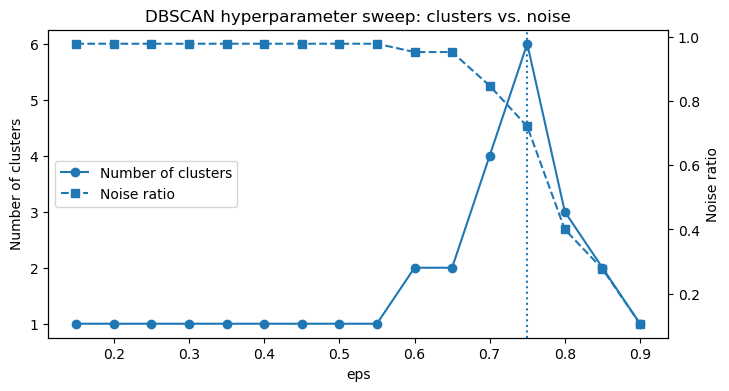

In [427]:
import matplotlib.pyplot as plt

best_eps = 0.75

fig, ax1 = plt.subplots(figsize=(8,4))

l1 = ax1.plot(grid_df["eps"], grid_df["n_clusters"], marker="o", linestyle="-",
              label="Number of clusters")
ax1.set_xlabel("eps")
ax1.set_ylabel("Number of clusters")

ax2 = ax1.twinx()
l2 = ax2.plot(grid_df["eps"], grid_df["noise_ratio"], marker="s", linestyle="--",
              label="Noise ratio")
ax2.set_ylabel("Noise ratio")

ax1.axvline(best_eps, linestyle=":")

lines = l1 + l2
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="center left")

ax1.set_title("DBSCAN hyperparameter sweep: clusters vs. noise")
plt.show()

This figure shows a DBSCAN hyperparameter sweep, illustrating the trade-off between the number of inferred clusters and the proportion of noise as the eps parameter varies.
We select eps = 0.75 as it yields multiple meaningful clusters while avoiding both excessive noise (small eps) and cluster collapse into a single dominant group (large eps).

In [394]:
best_eps = 0.75
db = DBSCAN(eps=best_eps, min_samples=10, metric="cosine")

df["role_cluster"] = db.fit_predict(X)

df["role_cluster"].value_counts()

role_cluster
-1    341
 0     38
 3     36
 4     28
 5     12
 1     10
 2      8
Name: count, dtype: int64

In [396]:
df[df["role_cluster"] != -1] \
  .groupby("role_cluster")["job_title"] \
  .apply(lambda s: s.head(8).tolist())

role_cluster
0    [Data Analytics, Data Scientist, data scientis...
1    [Junior Backend Big Data Developer, Data Scien...
2    [data scientist!, Customer Data Engineer, Data...
3    [Junior Product Manager, Junior Project Manage...
4    [Computer Hardware Engineer, Electrical Engine...
5    [Calculation Engineer, Electromechanical Engin...
Name: job_title, dtype: object

The inferred clusters correspond to coherent occupational domains (data, backend, product, hardware, mechanical), indicating that the clustering captures meaningful role structure.

In [399]:
def skills_to_set(cell):
    if pd.isna(cell) or not str(cell).strip():
        return set()
    s = str(cell).strip("[]")
    return set([x.strip().lower() for x in s.split(",") if x.strip()])

df["skill_set"] = df["skills"].apply(skills_to_set)

df[["job_title", "skill_set"]].head(3)

,job_title,skill_set
0,Data Analytics,"{kafka, leadership, organization, problem_solv..."
1,Junior Backend Big Data Developer,"{problem_solving, development, inclusive, init..."
2,Data Annotator,"{video, python, organization, identify discrep..."


Intra-cluster similarity

In [402]:
from itertools import combinations
import numpy as np

def jaccard(a, b):
    return len(a & b) / len(a | b) if (a or b) else 0.0

intra_scores = []

for c in sorted(df["role_cluster"].unique()):
    if c == -1:
        continue  # מדלגים על noise

    idx = df.index[df["role_cluster"] == c]
    if len(idx) < 2:
        continue

    sims = []
    for i, j in combinations(idx[:40], 2):  # cap לביצועים
        sims.append(jaccard(df.at[i, "skill_set"], df.at[j, "skill_set"]))

    intra_scores.append(np.mean(sims))

mean_intra = np.mean(intra_scores)
mean_intra

0.4680623117315242

mean_inter between clusters

In [408]:
import numpy as np

clusters = [c for c in df["role_cluster"].unique() if c != -1]
inter_scores = []

for i in range(len(clusters)):
    for j in range(i + 1, len(clusters)):
        ci, cj = clusters[i], clusters[j]

        idx_i = df.index[df["role_cluster"] == ci][:25]
        idx_j = df.index[df["role_cluster"] == cj][:25]

        sims = [
            jaccard(df.at[a, "skill_set"], df.at[b, "skill_set"])
            for a in idx_i for b in idx_j
        ]

        inter_scores.append(np.mean(sims))

mean_inter = float(np.mean(inter_scores))
mean_inter

0.11879090466743322

In [413]:
similarity_gap = mean_intra - mean_inter
mean_intra, mean_inter, similarity_gap

(0.4680623117315242, 0.11879090466743322, 0.349271407064091)

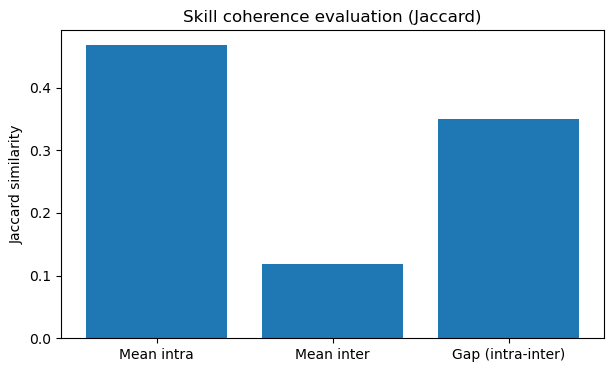

In [430]:
import matplotlib.pyplot as plt

values = [mean_intra, mean_inter, similarity_gap]
labels = ["Mean intra", "Mean inter", "Gap (intra-inter)"]

plt.figure(figsize=(7,4))
plt.bar(labels, values)
plt.ylabel("Jaccard similarity")
plt.title("Skill coherence evaluation (Jaccard)")
plt.show()

We evaluate skill extraction quality using an intra–inter cluster similarity gap.
Average Jaccard similarity of extracted skills within clusters is 0.47, compared to 0.12 across clusters, yielding a similarity gap of 0.35.
This indicates that extracted skills form coherent and role-specific profiles.

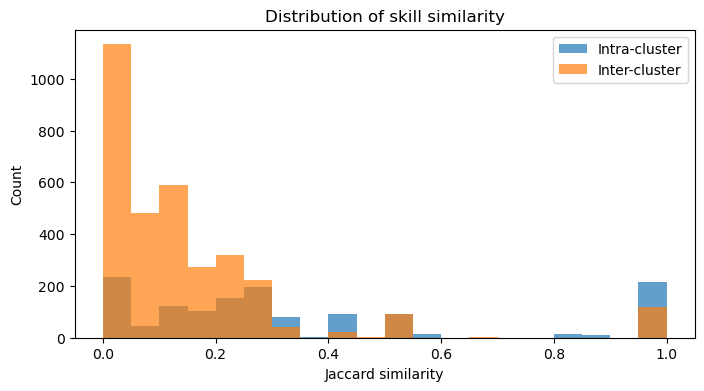

In [432]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# sample within-cluster similarities
rng = np.random.default_rng(42)

def sample_intra_values(df, max_per_cluster=30, max_pairs=2000):
    vals = []
    for c in sorted(df["role_cluster"].unique()):
        if c == -1:
            continue
        idx = df.index[df["role_cluster"] == c].tolist()[:max_per_cluster]
        if len(idx) < 2:
            continue
        pairs = list(combinations(idx, 2))
        if len(pairs) > max_pairs:
            pairs = rng.choice(pairs, size=max_pairs, replace=False)
        for i, j in pairs:
            vals.append(jaccard(df.at[i, "skill_set"], df.at[j, "skill_set"]))
    return np.array(vals)

def sample_inter_values(df, clusters, max_per_cluster=20, max_pairs_per_combo=1500):
    vals = []
    for i in range(len(clusters)):
        for j in range(i+1, len(clusters)):
            ci, cj = clusters[i], clusters[j]
            idx_i = df.index[df["role_cluster"] == ci].tolist()[:max_per_cluster]
            idx_j = df.index[df["role_cluster"] == cj].tolist()[:max_per_cluster]
            pairs = [(a,b) for a in idx_i for b in idx_j]
            if len(pairs) > max_pairs_per_combo:
                pairs = rng.choice(pairs, size=max_pairs_per_combo, replace=False)
            for a, b in pairs:
                vals.append(jaccard(df.at[a, "skill_set"], df.at[b, "skill_set"]))
    return np.array(vals)

clusters = [c for c in df["role_cluster"].unique() if c != -1]

intra_vals = sample_intra_values(df)
inter_vals = sample_inter_values(df, clusters)

plt.figure(figsize=(8,4))
plt.hist(intra_vals, bins=20, alpha=0.7, label="Intra-cluster")
plt.hist(inter_vals, bins=20, alpha=0.7, label="Inter-cluster")
plt.xlabel("Jaccard similarity")
plt.ylabel("Count")
plt.title("Distribution of skill similarity")
plt.legend()
plt.show()

Jaccard similarity quantifies the degree of overlap between two skill sets.

This histogram compares the distribution of Jaccard similarity between extracted skill sets for job pairs within the same DBSCAN cluster (intra-cluster) versus pairs from different clusters (inter-cluster).
The intra-cluster distribution is shifted to higher similarity values, indicating that extracted skills are more coherent within inferred roles than across roles.